## Imports

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import svm
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

%matplotlib inline

In [2]:
# Let's see how long this takes to run
run_start = time.time()

# Prepare Data

In [3]:
# read the csv files
#     subreddits: history jokes science research

target_subred_df = pd.read_csv('history_posts.csv')
alt_subred_df = pd.read_csv('science_posts.csv')

In [4]:
# balance classes by removing extra posts in history (undersampling)
alt_subred_df = alt_subred_df.head(target_subred_df.shape[0])
alt_subred_df.shape

(666, 94)

In [5]:
# only include the columns we're interested in
target_subred_df = target_subred_df[['title', 'ups', 'downs', 'num_comments', 'selftext']]
alt_subred_df = alt_subred_df[['title', 'ups', 'downs', 'num_comments', 'selftext']]

# assign target variable
target_subred_df['is_target'] = 1
alt_subred_df['is_target'] = 0

In [6]:
# combine into one df
master_df = pd.concat([target_subred_df, alt_subred_df])
master_df.reset_index(drop=True, inplace=True)

# Tokenizing and Vectorizing

In [7]:
# make a list of all the words in the train set
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
title_lists = []

stemmer = PorterStemmer()

# loop through each title and stem
for title in master_df['title']:
    title_words =  tokenizer.tokenize(title.lower())
    title_str = ''
    for word in title_words:
        token = stemmer.stem(word)
        title_str = title_str + token + ' '
    title_lists.append(title_str)

token_col = pd.Series(title_lists)

In [8]:
# create X and y
X = token_col
y = master_df['is_target']

# train-test-split
text_X_train, text_X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [9]:
# who you callin' corpus
train_corpus = list(text_X_train)
test_corpus = list(text_X_test)

In [10]:
# Vectorize
vect = TfidfVectorizer(ngram_range=(1,3), max_features=1500, stop_words=['research'])
raw_vec_train = vect.fit_transform(train_corpus)
X_train = pd.DataFrame(raw_vec_train.toarray(), columns = vect.get_feature_names())

# Do the same thing for the test set
raw_vec_test = vect.transform(test_corpus)
X_test = pd.DataFrame(raw_vec_test.toarray(), columns = vect.get_feature_names())

<hr>

# Functions:

### Define Model Fitting Function

In [11]:
index_labels = ['Test score','Train score', 'Sensitivity', 'Specificity', 'Precision', 
                'Best Params', 'Params Tried', 'Notes']

all_results = pd.DataFrame(index=index_labels)

# set dataframe options to display long strings rather than truncating them
pd.set_option('display.max_colwidth', 10000)

In [12]:
def fit_model(model, model_name, params, all_results, notes): # all_params
    start_time = time.time()

    # fit the model
    model = GridSearchCV(model, params, n_jobs=-1, cv = 3)
    model.fit(X_train, y_train)
    
    # pick out the best model
    best_model = model.best_estimator_
    
    # make the confusion matrix
    pred = best_model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    
    # Calculate results
    result = pd.DataFrame(index = index_labels, columns=[model_name])
    result.loc['Test score'][model_name] = round(best_model.score(X_test, y_test), 3)
    result.loc['Train score'][model_name] = round(model.best_score_, 3)
    result.loc['Sensitivity'][model_name] = round(tp/(tp+fn), 3)
    result.loc['Specificity'][model_name] = round(tn/(tn+fp), 3)
    result.loc['Precision'][model_name] = round(tp/(tp+fp), 3)
    
    # Parameters and Notes
    result.loc['Best Params'][model_name] = model.best_params_
    result.loc['Params Tried'][model_name] = params
    result.loc['Notes'][model_name] = notes

    # display test results
    display(result.head(result.shape[0]-3))
    
    # display parameters and notes
    display(result.tail(3))     

    # add results and params to all_results and all_params
    all_results = pd.concat([all_results, result], axis=1)

    # Create the confusion matrix
    total = (tp + tn + fp + fn)
    confusion = pd.DataFrame(index= ['Pred. Positive','Pred. Negative', 'Total'])
    confusion['Act. Positive'] = str(round(tp/total*100, 1))+'%', str(round(fn/total*100, 1))+'%', (tp + fn)
    confusion['Act. Negative'] = str(round(fp/total*100, 1))+'%', str(round(tn/total*100, 1))+'%', (fp + tn)
    confusion['Total'] = (tp + fp), (fn + tn), total
    display(confusion)
    
    # print the runtime
    end_time = time.time()
    print('Runtime: ', round((end_time - start_time)/60, 3), ' minutes')
    return all_results, best_model, pred

### ROC Curve Plotting Function

In [13]:
# ROC-AUC curve
def make_roc(y_test, best_model):

    # make predicted probabilities to be returned for use in the ROC Curve
    y_hat_proba = best_model.predict_proba(X_test)

    # Generate False positive rate and True positive rate
    fpr, tpr, _ = roc_curve(y_test, y_hat_proba[:,1])
    roc_auc = auc(fpr, tpr)

    # Plot settings
    plt.figure(figsize=(6, 4))
    line_width = 4
    
    plt.title('ROC Curve', fontsize=25, position = (0.2,1))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    string = 'Area Under Curve: ' + str(round(roc_auc, 3))
    plt.text(x=1, y=0.05, s=string, horizontalalignment='right')
    
    plt.grid(True)
    plt.plot(fpr, tpr, lw = line_width)
    plt.plot([0, 1], [0,1], lw = line_width, linestyle = '--');

<hr>
 
 # Models:

## Naive Bayes

,Naive Bayes
Test score,0.916
Train score,0.903
Sensitivity,0.911
Specificity,0.922
Precision,0.946


,Naive Bayes
Best Params,{'priors': None}
Params Tried,{'priors': [None]}
Notes,


,Act. Positive,Act. Negative,Total
Pred. Positive,54.5%,3.1%,239
Pred. Negative,5.3%,37.1%,176
Total,248,167,415


Runtime:  0.045  minutes


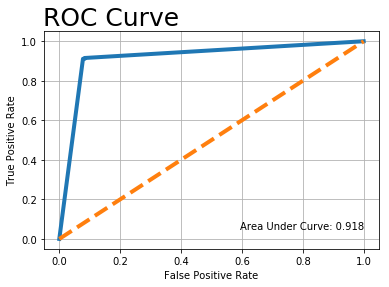

In [14]:
# Naive Bayes
#     GaussianNB() if tfidf
#     MultinomialNB() if countvec

# set parameters
nb_params = {'priors': [None]}

# Any notes to add?
nb_notes = ''

# call the fit_model function
all_results, nb_best_model, nb_preds = fit_model(GaussianNB(), 'Naive Bayes',
                                                 nb_params, all_results, nb_notes
                                                )

# Plot ROC Curve with make_roc function
make_roc(y_test, nb_best_model)

## Logisitic regression

/Users/zachgreen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,Logistic
Test score,0.933
Train score,0.933
Sensitivity,0.96
Specificity,0.892
Precision,0.93


,Logistic
Best Params,"{'C': 10, 'penalty': 'l2'}"
Params Tried,"{'penalty': ['l2', 'l1'], 'C': [1, 10, 25, 40, 50, 60, 75, 90, 100, 250]}"
Notes,


,Act. Positive,Act. Negative,Total
Pred. Positive,57.3%,4.3%,256
Pred. Negative,2.4%,35.9%,159
Total,248,167,415


Runtime:  0.042  minutes


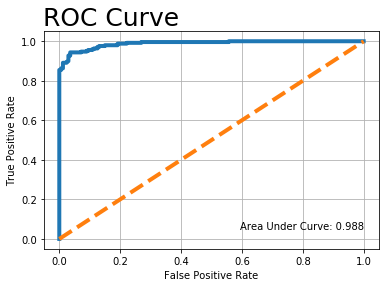

In [15]:
# Logisitic regression
lr_params = {
    'penalty': ['l2', 'l1'],
    'C': [1, 10, 25, 40, 50, 60, 75, 90, 100, 250]
}

# Any notes to add?
lr_notes = ''

all_results, lr_best_model, lr_preds = fit_model(LogisticRegression(), 'Logistic',
                                                 lr_params, all_results, lr_notes
                                                )

# Plot ROC Curve with make_roc function
make_roc(y_test, lr_best_model)

## Support Vector Machine

,SVM
Test score,0.942
Train score,0.933
Sensitivity,0.964
Specificity,0.91
Precision,0.941


,SVM
Best Params,"{'C': 1.1, 'kernel': 'linear'}"
Params Tried,"{'C': [1.1, 1.15, 1.2, 1.3, 1.5], 'kernel': ['linear', 'poly', 'rbf']}"
Notes,


,Act. Positive,Act. Negative,Total
Pred. Positive,57.6%,3.6%,254
Pred. Negative,2.2%,36.6%,161
Total,248,167,415


Runtime:  1.883  minutes


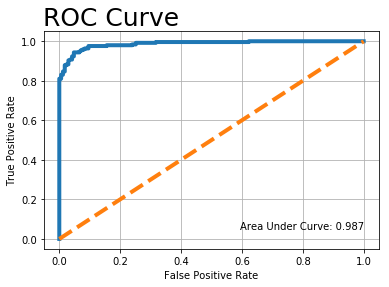

In [16]:
# SVM
svm_params = {
    'C': [1.1, 1.15, 1.2, 1.3, 1.5],
    'kernel': ['linear', 'poly', 'rbf'],
}

# Any notes to add?
svm_notes = ''

all_results, svm_best_model, svm_preds = fit_model(svm.SVC(probability=True), 'SVM',
                                                   svm_params, all_results, svm_notes
                                                  )


# Plot ROC Curve with make_roc function
make_roc(y_test, svm_best_model)

## KNN

,KNN
Test score,0.858
Train score,0.895
Sensitivity,0.972
Specificity,0.689
Precision,0.823


,KNN
Best Params,"{'metric': 'minkowski', 'n_neighbors': 40, 'p': 2, 'weights': 'uniform'}"
Params Tried,"{'n_neighbors': [25, 40, 50, 75, 100], 'weights': ['distance', 'uniform'], 'metric': ['minkowski'], 'p': [1, 2, 3, 5]}"
Notes,


,Act. Positive,Act. Negative,Total
Pred. Positive,58.1%,12.5%,293
Pred. Negative,1.7%,27.7%,122
Total,248,167,415


Runtime:  7.974  minutes


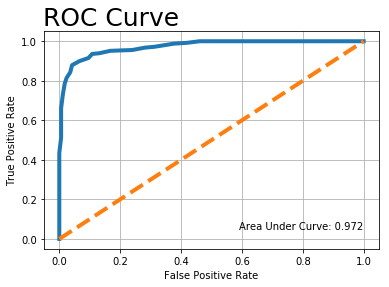

In [17]:
# KNN
knn_params = {
    'n_neighbors': [25, 40, 50, 75, 100],
    'weights': ['distance', 'uniform'],
    'metric': ['minkowski'],
    'p': [1, 2, 3, 5] #p=1 and p=2 correspond to manhattan and euclidean distance equations respectively
}

# Any notes to add?
knn_notes = ''

all_results, knn_best_model, knn_preds = fit_model(KNeighborsClassifier(), 'KNN',
                                                   knn_params, all_results, knn_notes
                                                  )

# Plot ROC Curve with make_roc function
make_roc(y_test, knn_best_model)

## Random Forest

,Random Forest
Test score,0.904
Train score,0.896
Sensitivity,0.976
Specificity,0.796
Precision,0.877


,Random Forest
Best Params,"{'bootstrap': False, 'max_features': 28, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 90}"
Params Tried,"{'n_estimators': [50, 60, 75, 90, 100, 125], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [2, 3, 4, 5], 'bootstrap': [False, True], 'max_features': (19, 28, 37, 46, 55)}"
Notes,


,Act. Positive,Act. Negative,Total
Pred. Positive,58.3%,8.2%,276
Pred. Negative,1.4%,32.0%,139
Total,248,167,415


Runtime:  13.059  minutes


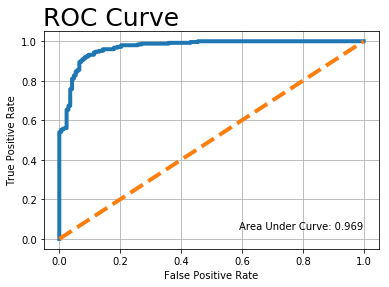

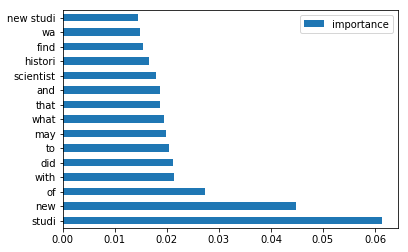

In [18]:
# Random Forest Model
rf_params = {
    'n_estimators': [50, 60, 75, 90, 100, 125],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [2, 3, 4, 5],
    'bootstrap': [False, True],
    'max_features': range(
                        int(np.sqrt(len(X_train.columns)))-int(.5*np.sqrt(len(X_train.columns))), # .5 Lower bound
                        int(np.sqrt(len(X_train.columns)))+int(.5*np.sqrt(len(X_train.columns))), # .5 Upper bound
                        int(.25*np.sqrt(len(X_train.columns)))) # Step size: .25)
}

# Any notes to add?
rf_notes = ''

all_results, rf_best_model, rf_preds = fit_model(RandomForestClassifier(), 'Random Forest',
                                                 rf_params, all_results, rf_notes
                                                )

# Plot ROC Curve with make_roc function
make_roc(y_test, rf_best_model)

# plot important features
feat_importance = pd.DataFrame(rf_best_model.feature_importances_, X_train.columns, columns=['importance'])
feat_importance.sort_values('importance', ascending=False).head(15).plot(kind='barh')

## Extra Trees

,Extra Trees
Test score,0.923
Train score,0.89
Sensitivity,0.98
Specificity,0.838
Precision,0.9


,Extra Trees
Best Params,"{'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 100}"
Params Tried,"{'n_estimators': [50, 75, 100], 'min_samples_split': [4], 'min_samples_leaf': [3]}"
Notes,


,Act. Positive,Act. Negative,Total
Pred. Positive,58.6%,6.5%,270
Pred. Negative,1.2%,33.7%,145
Total,248,167,415


Runtime:  0.133  minutes


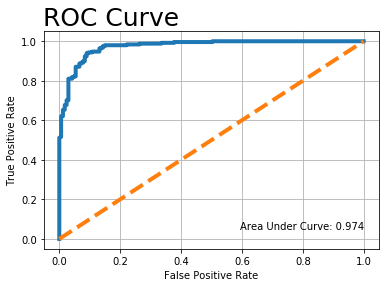

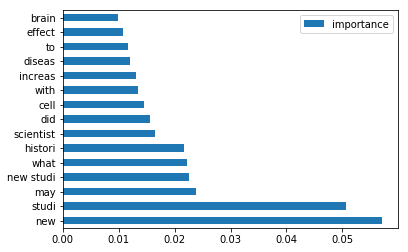

In [19]:
# Extra Trees
et_params = {
    'n_estimators': [50, 75, 100],
    'min_samples_split': [4],
    'min_samples_leaf': [3],
}

# Any notes to add?
et_notes = ''

all_results, et_best_model, et_preds = fit_model(ExtraTreesClassifier(), 'Extra Trees',
                                                 et_params, all_results, et_notes
                                                )

# Plot ROC Curve with make_roc function
make_roc(y_test, et_best_model)

# plot important features
feat_importance = pd.DataFrame(et_best_model.feature_importances_, X_train.columns, columns=['importance'])
feat_importance.sort_values('importance', ascending=False).head(15).plot(kind='barh')

## Gradient Boost

,Gradient Boost
Test score,0.894
Train score,0.86
Sensitivity,0.972
Specificity,0.778
Precision,0.867


,Gradient Boost
Best Params,"{'learning_rate': 0.4, 'max_depth': 4, 'min_samples_split': 3, 'n_estimators': 80}"
Params Tried,"{'n_estimators': [60, 70, 80], 'learning_rate': [0.25, 0.4, 0.5, 0.6, 0.75], 'max_depth': [4], 'min_samples_split': [3]}"
Notes,


,Act. Positive,Act. Negative,Total
Pred. Positive,58.1%,8.9%,278
Pred. Negative,1.7%,31.3%,137
Total,248,167,415


Runtime:  1.999  minutes


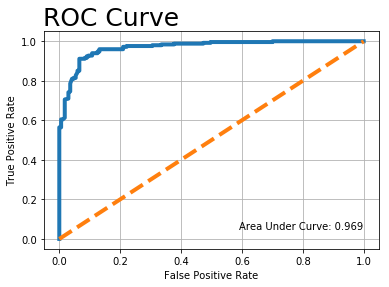

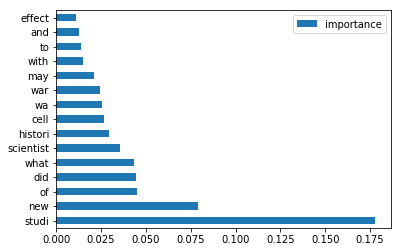

In [20]:
# Gradient Boost
gb_params = {
    'n_estimators': [60, 70, 80],
    'learning_rate': [.25, .4, .5, .6, .75],
    'max_depth': [4],
    'min_samples_split': [3],
}

# Any notes to add?
gb_notes = ''

all_results, gb_best_model, gb_preds = fit_model(GradientBoostingClassifier(), 'Gradient Boost',
                                                 gb_params, all_results, gb_notes
                                                )

# Plot ROC Curve with make_roc function
make_roc(y_test, gb_best_model)

# plot important features
feat_importance = pd.DataFrame(gb_best_model.feature_importances_, X_train.columns, columns=['importance'])
feat_importance.sort_values('importance', ascending=False).head(15).plot(kind='barh')

## AdaBoost

,AdaBoost
Test score,0.906
Train score,0.873
Sensitivity,0.952
Specificity,0.838
Precision,0.897


,AdaBoost
Best Params,"{'learning_rate': 1, 'n_estimators': 125}"
Params Tried,"{'n_estimators': [75, 100, 125, 150, 175], 'learning_rate': [0.1, 0.25, 0.5, 1]}"
Notes,


,Act. Positive,Act. Negative,Total
Pred. Positive,56.9%,6.5%,263
Pred. Negative,2.9%,33.7%,152
Total,248,167,415


Runtime:  1.31  minutes


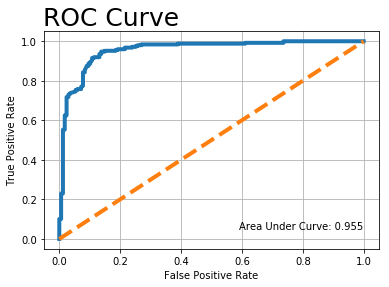

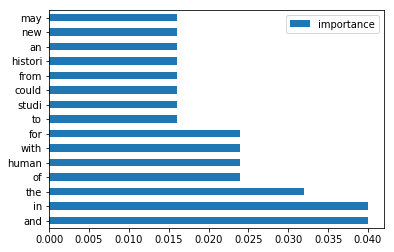

In [21]:
# Adaboost
ada_params = {
    'n_estimators': [75, 100, 125, 150, 175],
    'learning_rate': [.1, .25, .5, 1],
}

# Any notes to add?
ada_notes = ''

all_results, ada_best_model, ada_preds = fit_model(AdaBoostClassifier(), 'AdaBoost',
                                                   ada_params, all_results, ada_notes
                                                  )

# Plot ROC Curve with make_roc function
make_roc(y_test, ada_best_model)

# plot important features
feat_importance = pd.DataFrame(ada_best_model.feature_importances_, X_train.columns, columns=['importance'])
feat_importance.sort_values('importance', ascending=False).head(15).plot(kind='barh')

### Ensemble Models together

Combine predictions from all models into a single dataframe:

In [22]:
all_preds = pd.DataFrame()

for prediction in [lr_preds, svm_preds, ada_preds, rf_preds, nb_preds]: # gb_preds, et_preds, knn_preds
    seri = pd.Series(prediction)
    all_preds = pd.concat([all_preds, seri], axis=1)

In [23]:
ensem = pd.DataFrame()
ens_proba = pd.DataFrame()

# take the average of the predictions to get the probability of positive case (1)
ens_proba = all_preds.mean(axis=1)

# round to nearest integer to 'vote' on final prediction
ensem = round(ens_proba, 0)

all_preds['Ensemble'] = ensem
all_preds['Ensemble Proba'] = ens_proba

In [24]:
# calculate accuracy
print('Ensemble Model Accuracy: ', accuracy_score(y_test, all_preds['Ensemble']))

Ensemble Model Accuracy:  0.944578313253012


In [25]:
# Make df of probabilities of prediction classes
ens_proba_neg = 1 - ens_proba

proba_df = pd.concat([ens_proba_neg, ens_proba], axis=1)

#### Evaluate the Results:

,Ensemble
Test score,0.945
Train score,NaN
Sensitivity,0.984
Specificity,0.886
Precision,0.928
Best Params,NaN
Params Tried,NaN
Notes,NaN


,Act. Positive,Act. Negative,Total
Pred. Positive,58.8%,4.6%,263
Pred. Negative,1.0%,35.7%,152
Total,248,167,415


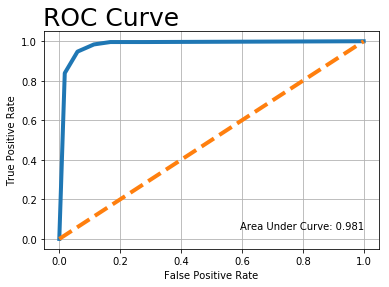

In [26]:
tn, fp, fn, tp = confusion_matrix(y_test, all_preds['Ensemble']).ravel()

model_name = 'Ensemble'

# Calculate results
result = pd.DataFrame(index = index_labels, columns=[model_name])
result.loc['Test score'][model_name] = round(accuracy_score(y_test, all_preds['Ensemble']), 3)
# result.loc['Train score'][model_name] = round(model.best_score_, 3)
result.loc['Sensitivity'][model_name] = round(tp/(tp+fn), 3)
result.loc['Specificity'][model_name] = round(tn/(tn+fp), 3)
result.loc['Precision'][model_name] = round(tp/(tp+fp), 3)

# display test results
display(result)     

# add results and params to all_results and all_params
all_results = pd.concat([all_results, result], axis=1)

# Create the confusion matrix
total = (tp + tn + fp + fn)
confusion = pd.DataFrame(index= ['Pred. Positive','Pred. Negative', 'Total'])
confusion['Act. Positive'] = str(round(tp/total*100, 1))+'%', str(round(fn/total*100, 1))+'%', (tp + fn)
confusion['Act. Negative'] = str(round(fp/total*100, 1))+'%', str(round(tn/total*100, 1))+'%', (fp + tn)
confusion['Total'] = (tp + fp), (fn + tn), total
display(confusion)

# make predicted probabilities to be returned for use in the ROC Curve
y_hat_proba = proba_df.values

# Generate False positive rate and True positive rate
fpr, tpr, _ = roc_curve(y_test, y_hat_proba[:,1])
roc_auc = auc(fpr, tpr)

# Plot settings
plt.figure(figsize=(6, 4))
line_width = 4

plt.title('ROC Curve', fontsize=25, position = (0.2,1))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

string = 'Area Under Curve: ' + str(round(roc_auc, 3))
plt.text(x=1, y=0.05, s=string, horizontalalignment='right')

plt.grid(True)
plt.plot(fpr, tpr, lw = line_width)
plt.plot([0, 1], [0,1], lw = line_width, linestyle = '--');

 <hr>
 
 # Overall Results:

In [27]:
# Display scores from all models
display(all_results.head(all_results.shape[0] - 3))

# Show which parameters worked best
display(all_results.tail(3))

# Calculate how long it took to run
run_end = time.time()
print('Runtime: ', round((run_end - run_start)/60, 3), ' minutes')

,Naive Bayes,Logistic,SVM,KNN,Random Forest,Extra Trees,Gradient Boost,AdaBoost,Ensemble
Test score,0.916,0.933,0.942,0.858,0.904,0.923,0.894,0.906,0.945
Train score,0.903,0.933,0.933,0.895,0.896,0.89,0.86,0.873,NaN
Sensitivity,0.911,0.96,0.964,0.972,0.976,0.98,0.972,0.952,0.984
Specificity,0.922,0.892,0.91,0.689,0.796,0.838,0.778,0.838,0.886
Precision,0.946,0.93,0.941,0.823,0.877,0.9,0.867,0.897,0.928


,Naive Bayes,Logistic,SVM,KNN,Random Forest,Extra Trees,Gradient Boost,AdaBoost,Ensemble
Best Params,{'priors': None},"{'C': 10, 'penalty': 'l2'}","{'C': 1.1, 'kernel': 'linear'}","{'metric': 'minkowski', 'n_neighbors': 40, 'p': 2, 'weights': 'uniform'}","{'bootstrap': False, 'max_features': 28, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 90}","{'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 100}","{'learning_rate': 0.4, 'max_depth': 4, 'min_samples_split': 3, 'n_estimators': 80}","{'learning_rate': 1, 'n_estimators': 125}",NaN
Params Tried,{'priors': [None]},"{'penalty': ['l2', 'l1'], 'C': [1, 10, 25, 40, 50, 60, 75, 90, 100, 250]}","{'C': [1.1, 1.15, 1.2, 1.3, 1.5], 'kernel': ['linear', 'poly', 'rbf']}","{'n_neighbors': [25, 40, 50, 75, 100], 'weights': ['distance', 'uniform'], 'metric': ['minkowski'], 'p': [1, 2, 3, 5]}","{'n_estimators': [50, 60, 75, 90, 100, 125], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [2, 3, 4, 5], 'bootstrap': [False, True], 'max_features': (19, 28, 37, 46, 55)}","{'n_estimators': [50, 75, 100], 'min_samples_split': [4], 'min_samples_leaf': [3]}","{'n_estimators': [60, 70, 80], 'learning_rate': [0.25, 0.4, 0.5, 0.6, 0.75], 'max_depth': [4], 'min_samples_split': [3]}","{'n_estimators': [75, 100, 125, 150, 175], 'learning_rate': [0.1, 0.25, 0.5, 1]}",NaN
Notes,,,,,,,,,NaN


Runtime:  26.566  minutes


<hr>

<br>